# Credit Risk Mini‑Case
**Dataset:** Give Me Some Credit (`cs-training.csv`)

**Objective:** Build a PD model (baseline logistic regression), then design an approval cut‑off that maximizes **expected profit** under optional **risk appetite constraints**.

**How to use in Colab:** upload `cs-training.csv`, then **Runtime → Run all**.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from IPython.display import display

DATA_PATH = "cs-training.csv"  # change if needed
SEED = 42


In [10]:
# Load
df = pd.read_csv(DATA_PATH)
df = df.set_index("Unnamed: 0")
target = "SeriousDlqin2yrs"

y = df[target].astype(int)
X = df.drop(columns=[target])

N = len(df)
base_rate = y.mean()
print(f"Rows: {N:,} | Features: {X.shape[1]} | Base default rate: {base_rate:.2%}")

# Split (60/20/20, stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)


Rows: 150,000 | Features: 10 | Base default rate: 6.68%
Train/Valid/Test: (90000, 10) (30000, 10) (30000, 10)


In [11]:
from dataclasses import dataclass

def ks_stat(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(np.abs(tpr - fpr)))

@dataclass
class PreprocParams:
    medians: pd.Series
    q_low: pd.Series
    q_high: pd.Series

def fit_preproc_params(X_train: pd.DataFrame, low_q=0.01, high_q=0.99) -> PreprocParams:
    med = X_train.median(numeric_only=True)
    ql = X_train.quantile(low_q, numeric_only=True)
    qh = X_train.quantile(high_q, numeric_only=True)
    return PreprocParams(medians=med, q_low=ql, q_high=qh)

def apply_preproc(X: pd.DataFrame, params: PreprocParams) -> pd.DataFrame:
    Xp = X.copy()

    # Missingness flags
    for col in ["MonthlyIncome", "NumberOfDependents"]:
        if col in Xp.columns:
            Xp[f"{col}_missing"] = Xp[col].isna().astype(int)

    # Delinquency flags
    delin_cols = [
        "NumberOfTime30-59DaysPastDueNotWorse",
        "NumberOfTime60-89DaysPastDueNotWorse",
        "NumberOfTimes90DaysLate",
    ]
    for col in delin_cols:
        if col in Xp.columns:
            Xp[f"{col}_gt0"] = (Xp[col].fillna(0) > 0).astype(int)

    if all(col in Xp.columns for col in delin_cols):
        Xp["any_delinquency"] = (
            (Xp[delin_cols[0]].fillna(0) > 0) |
            (Xp[delin_cols[1]].fillna(0) > 0) |
            (Xp[delin_cols[2]].fillna(0) > 0)
        ).astype(int)

    # Impute with train medians
    for col in params.medians.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].fillna(params.medians[col])

    # Cap outliers with train quantiles
    for col in params.q_low.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].clip(params.q_low[col], params.q_high[col])

    return Xp

def decile_table(y_true: np.ndarray, score: np.ndarray, n_bins=10) -> pd.DataFrame:
    d = pd.DataFrame({"y": np.asarray(y_true), "score": np.asarray(score)})
    d["decile"] = pd.qcut(d["score"], q=n_bins, labels=False, duplicates="drop") + 1  # 1 low risk, 10 high risk
    out = (d.groupby("decile", as_index=False)
             .agg(n=("y", "size"),
                  bads=("y", "sum"),
                  avg_pd=("score", "mean")))
    out["bad_rate"] = out["bads"] / out["n"]
    out["share_of_bads"] = out["bads"] / out["bads"].sum()
    out["cum_share_of_bads"] = out["share_of_bads"].cumsum()
    out = out.sort_values("decile").reset_index(drop=True)
    return out

def profit_curve(y_true, pd_score, R=15.0, L=300.0, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.001, 0.5, 400)  # practical PD range
    y_true = np.asarray(y_true)
    pd_score = np.asarray(pd_score)
    rows = []
    for t in thresholds:
        approved = pd_score < t
        if approved.sum() == 0:
            continue
        approval_rate = approved.mean()
        bad_rate = y_true[approved].mean()
        exp_profit_total = ((1 - pd_score[approved]) * R - pd_score[approved] * L).sum()
        profit_per_applicant = exp_profit_total / len(pd_score)
        rows.append([t, approval_rate, bad_rate, profit_per_applicant])
    return pd.DataFrame(rows, columns=["threshold", "approval_rate", "bad_rate", "profit_per_applicant"])

def psi(expected: np.ndarray, actual: np.ndarray, n_bins: int = 10, eps: float = 1e-6) -> float:
    expected = np.asarray(expected)
    actual = np.asarray(actual)
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]

    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.unique(np.quantile(expected, quantiles))
    if len(bins) < 3:
        return 0.0

    e_counts, _ = np.histogram(expected, bins=bins)
    a_counts, _ = np.histogram(actual,   bins=bins)

    e_perc = e_counts / max(e_counts.sum(), 1)
    a_perc = a_counts / max(a_counts.sum(), 1)

    e_perc = np.clip(e_perc, eps, 1)
    a_perc = np.clip(a_perc, eps, 1)

    return float(np.sum((a_perc - e_perc) * np.log(a_perc / e_perc)))


In [12]:
# Preprocess (fit on TRAIN only)
params = fit_preproc_params(X_train, low_q=0.01, high_q=0.99)
Xtr = apply_preproc(X_train, params)
Xva = apply_preproc(X_valid, params)
Xte = apply_preproc(X_test,  params)

# Model: Logistic Regression (industry baseline) + calibration
base_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # safe even after preproc
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

cal_model = CalibratedClassifierCV(base_model, method="sigmoid", cv=3)
cal_model.fit(Xtr, y_train)

p_test = cal_model.predict_proba(Xte)[:, 1]
p_valid = cal_model.predict_proba(Xva)[:, 1]
p_train = cal_model.predict_proba(Xtr)[:, 1]

auc = roc_auc_score(y_test, p_test)
ks = ks_stat(y_test, p_test)

psi_score = psi(p_train, p_test, n_bins=10)

print(f"Test ROC-AUC: {auc:.3f} | Test KS: {ks:.3f} | PSI(train→test score): {psi_score:.3f}")


Test ROC-AUC: 0.860 | Test KS: 0.559 | PSI(train→test score): 0.000


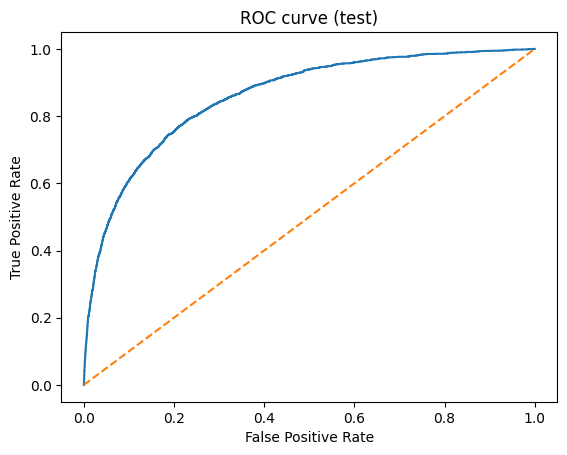

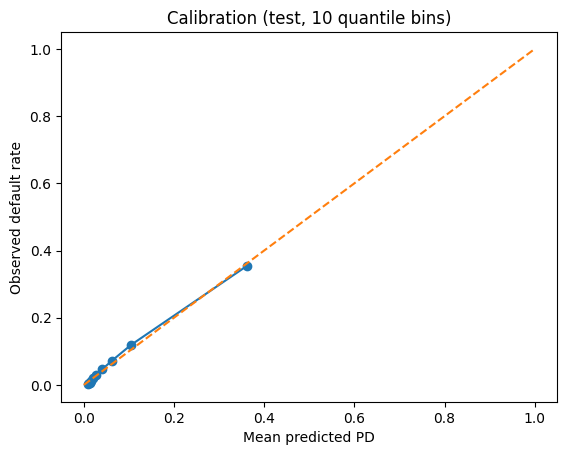

In [13]:
# Visual 1: ROC curve
fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test)")
plt.show()

# Visual 2: Calibration curve
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Mean predicted PD")
plt.ylabel("Observed default rate")
plt.title("Calibration (test, 10 quantile bins)")
plt.show()


,decile,n,bads,avg_pd,bad_rate,share_of_bads,cum_share_of_bads
0,1,3000,12,0.008291,0.004000,0.005985,0.005985
1,2,3000,17,0.011377,0.005667,0.008479,0.014464
2,3,3000,21,0.013944,0.007000,0.010474,0.024938
3,4,3000,38,0.016875,0.012667,0.018953,0.043890
4,5,3000,61,0.020841,0.020333,0.030424,0.074314
5,6,3000,86,0.027625,0.028667,0.042893,0.117207
6,7,3000,139,0.040497,0.046333,0.069327,0.186534
7,8,3000,214,0.061603,0.071333,0.106733,0.293267
8,9,3000,356,0.104291,0.118667,0.177556,0.470823
9,10,3000,1061,0.361133,0.353667,0.529177,1.000000


Highest-risk decile captures 52.9% of bads; bad rate = 35.4%


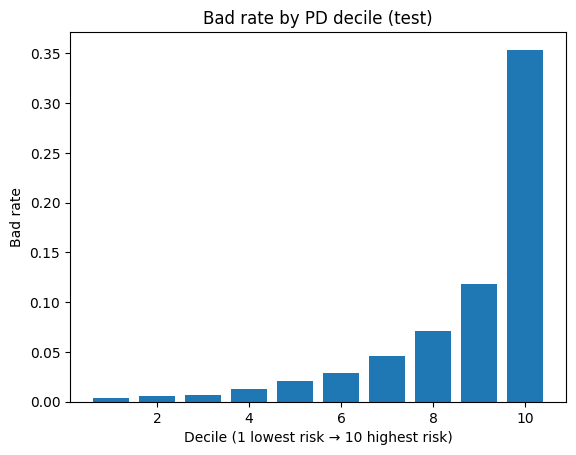

In [14]:
# Visual 3: Decile / lift table
dec = decile_table(y_test, p_test, n_bins=10)
display(dec)

top = dec[dec["decile"] == dec["decile"].max()].iloc[0]  # highest risk decile
print(f"Highest-risk decile captures {top['share_of_bads']:.1%} of bads; bad rate = {top['bad_rate']:.1%}")

plt.figure()
plt.bar(dec["decile"], dec["bad_rate"])
plt.xlabel("Decile (1 lowest risk → 10 highest risk)")
plt.ylabel("Bad rate")
plt.title("Bad rate by PD decile (test)")
plt.show()


In [16]:
def best_under_constraint(curve, bad_rate_max=None, approval_min=None):
    """
    curve: DataFrame with columns:
      - threshold
      - approval_rate
      - bad_rate
      - profit_per_applicant
    Returns a Series (best row) or None if no feasible thresholds.
    """
    c = curve.copy()

    if bad_rate_max is not None:
        c = c[c["bad_rate"] <= bad_rate_max]
    if approval_min is not None:
        c = c[c["approval_rate"] >= approval_min]

    if len(c) == 0:
        return None

    idx = c["profit_per_applicant"].idxmax()
    return c.loc[idx]


Unconstrained optimum:


,35
threshold,0.047273
approval_rate,0.688400
bad_rate,0.017190
profit_per_applicant,6.110443


Best under constraints:


,35
threshold,0.047273
approval_rate,0.688400
bad_rate,0.017190
profit_per_applicant,6.110443


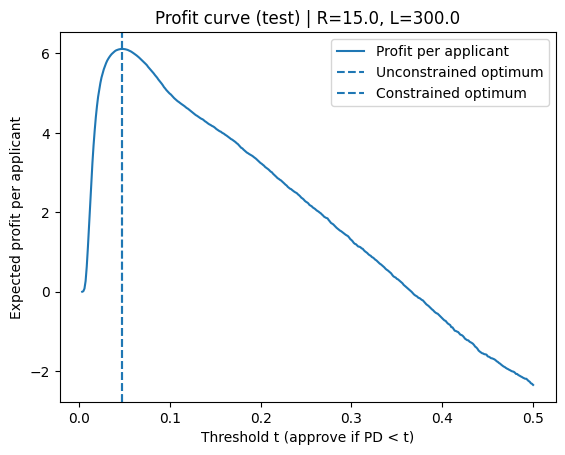

In [17]:
# Decision policy: maximize expected profit (edit economics)
R = 15.0    # profit per good approved loan
L = 300.0   # loss per bad approved loan

curve = profit_curve(y_test, p_test, R=R, L=L)

best = curve.loc[curve["profit_per_applicant"].idxmax()]
print("Unconstrained optimum:")
display(best)

# Optional constraints (risk appetite / growth)
BAD_RATE_MAX = 0.02   # set None to disable
APPROVAL_MIN = None   # e.g. 0.65, set None to disable

best_c = best_under_constraint(curve, bad_rate_max=BAD_RATE_MAX, approval_min=APPROVAL_MIN)
print("Best under constraints:")
display(best_c if best_c is not None else "No feasible thresholds")

plt.figure()
plt.plot(curve["threshold"], curve["profit_per_applicant"], label="Profit per applicant")
plt.axvline(best["threshold"], linestyle="--", label="Unconstrained optimum")
if best_c is not None:
    plt.axvline(best_c["threshold"], linestyle="--", label="Constrained optimum")
plt.xlabel("Threshold t (approve if PD < t)")
plt.ylabel("Expected profit per applicant")
plt.title(f"Profit curve (test) | R={R}, L={L}")
plt.legend()
plt.show()


In [18]:
# Champion vs Challenger (example champion threshold)
def policy_metrics(y_true, pd_score, t, R, L):
    y_true = np.asarray(y_true)
    pd_score = np.asarray(pd_score)
    approved = pd_score < t
    approval_rate = approved.mean()
    bad_rate = y_true[approved].mean() if approved.sum() > 0 else np.nan
    exp_profit_total = ((1 - pd_score[approved]) * R - pd_score[approved] * L).sum() if approved.sum() > 0 else 0.0
    return pd.Series({
        "threshold": t,
        "approval_rate": approval_rate,
        "bad_rate": bad_rate,
        "profit_per_applicant": exp_profit_total / len(pd_score),
        "profit_per_approved": exp_profit_total / approved.sum() if approved.sum() > 0 else np.nan
    })

champion_t = 0.08
champ = policy_metrics(y_test, p_test, champion_t, R, L)
chall = policy_metrics(y_test, p_test, float(best["threshold"]), R, L)

comparison = pd.DataFrame([champ, chall], index=["Champion", "Challenger"])
display(comparison)

uplift = (comparison.loc["Challenger","profit_per_applicant"] / comparison.loc["Champion","profit_per_applicant"]) - 1
print(f"Profit uplift per applicant (Challenger vs Champion): {uplift:.1%}")


,threshold,approval_rate,bad_rate,profit_per_applicant,profit_per_approved
Champion,0.080000,0.811967,0.025165,5.552493,6.838326
Challenger,0.047273,0.688400,0.017190,6.110443,8.876298


Profit uplift per applicant (Challenger vs Champion): 10.0%


## Executive summary

**Model (holdout test, random_state=42):**
- Base rate: **6.68%**
- ROC‑AUC: **0.860**
- KS: **0.559**
- PSI(score) train→test: **0.0004** *(proxy for drift monitoring)*

**Risk segmentation (deciles by calibrated PD; Decile 1 = lowest risk, Decile 10 = highest risk):**
- **Decile 10** captures **52.9%** of all bads with **35.4%** bad rate.
- **Decile 1** bad rate is **0.40%**.

**Decisioning & profitability (example economics):**
- We optimize approval cut‑off using calibrated PDs and expected profit:  
  `E[profit] = (1 − PD) * R − PD * L`
- **Base scenario (R=15, L=300):**
  - Champion (simple rule): **PD < 0.080** → approval **81.2%**, bad rate **2.52%**, profit/applicant **5.55**
  - Challenger (profit‑optimal): **PD < 0.048** → approval **69.0%**, bad rate **1.72%**, profit/applicant **6.11**
  - Profit uplift: **10.1%** vs champion *(same R/L units)*

**Scenario sensitivity (profit‑optimal thresholds; and best under bad rate ≤2% when relevant):**
| Scenario | R | L | Opt t | Opt appr | Opt bad | Opt $/app | Opt t (bad≤2%) | Appr (bad≤2%) | Bad (bad≤2%) | $/app (bad≤2%) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| conservative | 15 | 600 | 0.024 | 51.2% | 1.02% | 3.12 | 0.024 | 51.2% | 1.02% | 3.12 |
| base | 15 | 300 | 0.048 | 69.0% | 1.72% | 6.11 | 0.048 | 69.0% | 1.72% | 6.11 |
| aggressive | 20 | 200 | 0.091 | 83.9% | 2.74% | 11.64 | 0.058 | 73.6% | 1.95% | 11.23 |

**Monitoring checklist (production mindset):**
- Weekly: approval rate, bad rate, expected profit KPIs
- Model quality: AUC/KS stability (by cohort/vintage once timestamps exist)
- Drift: PSI on score + key features; investigate when PSI is materially elevated
